In [68]:
import os
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [69]:
def compute_cross_covariace(src_points: np.array, dst_points: np.array, centroid_src_points: np.array, centroid_dst_points: np.array):
    '''
    Compute the cross-covariance between two set of point clouds.
    It will tell us how the coordinates of point in src_points change with changes in coodrinates of points belonging to dst_points
    
    Args:
        src_points(np.array): The coordinates of the first point cloud to correlate.
        dst_points(np.array): The coordinates of the second points to correlate with the first.
        centroid_src_points(np.array): Center position of all points in first point cloud, equivalent to get the mean of all the points
        centroid_dst_points(np.array): Center position of all points in second point cloud, equivalent to get the mean of all the points
    
    Return
        (np.array)(src_points.shape[1]xsrc_points.shape[1]): The cross-covariance matrix between the points
    '''
    centered_src_points: np.array = src_points - centroid_src_points
    centered_dst_points: np.array = dst_points - centroid_dst_points
    cov: np.array = np.dot(centered_src_points.T, centered_dst_points)
    return cov

def calculate_best_transform(src_points: np.array, dst_points: np.array):
    '''
    Calculates the best transform that maps  points between two point clouds.
    The cross-covariance matrix between the point clouds is calculated, then
    rotations and translations are extracted using singular value decomposition.
    
    Args:
      src_points(np.array): The coordinates of the first point cloud.
      dst_points(np.array): The coordiantes of the second point cloud.

    Returns:
        (np.array)(src_points.shape[1]+1)x(src_points.shape[1]+1) homogeneous transformation matrix that maps src_points on to dst_points
        (np.array)(src_points.shape[1]xsrc_points.shape[1]) rotation matrix
        (np.array)(src_points.shape[1]x1) translation vector
    '''
    # translate points to their centroids
    centroid_src_points = np.mean(src_points, axis=0)
    centroid_dst_points = np.mean(dst_points, axis=0)
    # compute covariance
    cov = compute_cross_covariace(src_points, dst_points, centroid_src_points, centroid_dst_points)
    # rotation matrix
    U, S, Vt = np.linalg.svd(cov)
    R = np.dot(Vt.T, U.T)
    # get number of dimensions
    m = src_points.shape[1]
    # special reflection case
    if np.linalg.det(R) < 0:
        Vt[m-1,:] *= -1
        R = np.dot(Vt.T, U.T)
    # translation
    t = centroid_dst_points.T - np.dot(R,centroid_src_points.T)
    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t
    return T, R, t

def nearest_neighbor(src_points: np.array, dst_points: np.array):
    '''
    Find the nearest neighbor between the point clouds
    
    Args:
      src_points(np.array): The coordinates of the first point cloud.
      dst_points(np.array): The coordiantes of the second point cloud.

    Return:
        (np.ndarray): Distances from the src_points to the closest points in dst_points
        (np.ndarray): Indices of the nearest points in the point clouds.
    '''
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst_points)
    neigh_dist, neigh_ind = neigh.kneighbors(src_points, return_distance=True)
    return neigh_dist.ravel(), neigh_ind.ravel()

def icp(src_points: np.array, dst_points: np.array, init_pose: np.array=None, max_iterations: int=20, tolerance: float=0.001):
    '''
    Finds best-fit transform that maps points in src_points on to points in dst_points
    using Iterative Closest Point method.

    Input:
        src_points(np.array): The coordinates of the first point cloud.
        dst_points(np.array): The coordiantes of the second point cloud.
        init_pose(np.array):  homogeneous transformation
        max_iterations(int): exit algorithm after max_iterations
        tolerance(float): convergence criteria
   
    Return:
        (np.array)(src_points.shape[1]+1)x(src_points.shape[1]+1) homogeneous transformation matrix that maps src_points on to dst_points
        Euclidean distances (errors) of the nearest neighbor
        number of iterations to converge
    '''
    # get number of dimensions
    m = src_points.shape[1]
    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1, src_points.shape[0]))
    dst = np.ones((m+1, dst_points.shape[0]))
    src[:m,:] = np.copy(src_points.T)
    dst[:m,:] = np.copy(dst_points.T)
    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)
    prev_error = 0
    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)
        # compute the transformation between the current source and nearest destination points
        T,_,_ = calculate_best_transform(src[:m,:].T, dst[:m,indices].T)
        # update the current source
        src = np.dot(T, src)
        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error
    # calculate final transformation
    T,_,_ = calculate_best_transform(src_points, src[:m,:].T)
    return T, distances, i

def icp_pos(src_points, dst_points, init_pose=None, max_iterations: int=20, tolerance: float=0.001):
    '''
    Translate position of src_points to match best-fit transform that maps points in src_points on to points in dst_points
    using Iterative Closest Point method.

     Input:
        src_points(np.array): The coordinates of the first point cloud.
        dst_points(np.array): The coordiantes of the second point cloud.
        init_pose(np.array):  homogeneous transformation
        max_iterations(int): exit algorithm after max_iterations
        tolerance(float): convergence criteria
   
    Return:
        (np.array)(src_points.shape): Translated src_points to match best-fit transform to points dst_points
    '''
    m = src_points.shape[1]
    T, distances, i = icp(src_points, dst_points, init_pose, max_iterations, tolerance)
    src = np.ones((m+1, src_points.shape[0]))
    src[:m,:] = np.copy(src_points.T)
    src = np.dot(T, src)
    return src[:m,:].T


In [70]:
data_dir_path = "{}/data".format(os.getcwd().rsplit("/", 1)[0])
src_points = np.load("{}/src_points.npy".format(data_dir_path))
dst_points = np.load("{}/dst_points.npy".format(data_dir_path))

result_pos = icp_pos(src_points, dst_points)

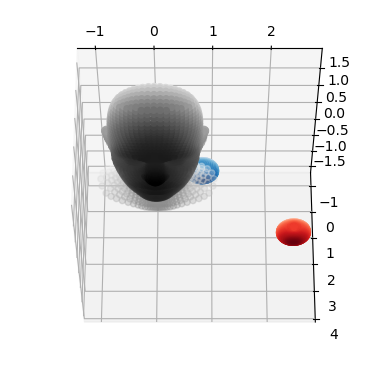

In [72]:
import matplotlib.pyplot as plt
ax = plt.axes(projection='3d')

# Data for a three-dimensional line

zdata = src_points[:,2]
xdata = src_points[:,0]
ydata = src_points[:,1]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Reds')
zdata = dst_points[:,2]
xdata = dst_points[:,0]
ydata = dst_points[:,1]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greys')
xdata = result_pos[:,2]
ydata = result_pos[:,0]
zdata = result_pos[:,1]
ax.view_init(150, -90)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Blues')